# Modèles d'apprentissage

__[III Modèles](#III-Modèles)__\
[III.1 Chargement et préparation du jeu de données](#III.1-Chargement-et-préparation-du-jeu-de-données)\
[III.2 Baseline: Régression linéaire simple](#III.2-Baseline:-Régression-linéaire-simple)\
[III.3 kNN](#III.3-kNN)\
[III.4 Sélection de prédicteurs avec Lasso](#III.4-Sélection-de-prédicteurs-avec-Lasso)\
[III.5 Feature importance avec RandomForest](#III.5-Feature-importance-avec-RandomForest)\
__[IV Choix du modèle](#IV-Choix-du-modèle)__\
__[V ENERGYSTARScore](#V-ENERGYSTARScore)__\
__[VI Prédiction de TotalGHGEmission](#VI-Prédiction-de-TotalGHGEmissions)__



In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# III Modèles
## III.1 Chargement et préparation du jeu de données

In [29]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

set_config(display='diagram')

Chargement du jeu de données nettoyé et préparé pour l'apprentissage

In [44]:
SEUmodel = pd.read_csv("./SEUmodel.csv")
GHGmodel = pd.read_csv("./GHGmodel.csv")
SEUmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 3375
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         1846 non-null   int64  
 1   YearBuilt                        1846 non-null   int64  
 2   NumberofBuildings                1846 non-null   float64
 3   NumberofFloors                   1846 non-null   float64
 4   PropertyGFATotal                 1846 non-null   int64  
 5   PropertyGFAParking               1846 non-null   int64  
 6   PropertyGFABuilding(s)           1846 non-null   int64  
 7   LargestPropertyUseTypeGFA        1846 non-null   float64
 8   SecondLargestPropertyUseType     1846 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1846 non-null   float64
 10  ThirdLargestPropertyUseType      1846 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1846 non-null   float64
 12  ENERGYSTARScore     

In [45]:
GHGmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 3375
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         1846 non-null   int64  
 1   YearBuilt                        1846 non-null   int64  
 2   NumberofBuildings                1846 non-null   float64
 3   NumberofFloors                   1846 non-null   float64
 4   PropertyGFATotal                 1846 non-null   int64  
 5   PropertyGFAParking               1846 non-null   int64  
 6   PropertyGFABuilding(s)           1846 non-null   int64  
 7   LargestPropertyUseTypeGFA        1846 non-null   float64
 8   SecondLargestPropertyUseType     1846 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1846 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   1846 non-null   float64
 11  ENERGYSTARScore                  1307 non-null   float64
 12  SiteEUI(kBtu/sf)    

In [86]:
def modelpreparation(model, targets=None, energy_cols=None):
    
    if not targets:
        # Sélection des cibles
        targets = ["SiteEnergyUse",
                   "SiteEnergyUse_log",
                   "TotalGHGEmissions", 
                   "TotalGHGEmissions_log",
                   "SiteEUI(kBtu/sf)",
                   "SiteEUIWN(kBtu/sf)",
                   "SourceEUI(kBtu/sf)",
                   "SourceEUIWN(kBtu/sf)",
                   "SiteEnergyUseWN(kBtu)",
                   "SourceEnergyUseWN",
                   "SourceEnergyUse(kBtu)", 
                   "GHGEmissionsIntensity"]
    
    if not energy_cols:
        # retrait des colonnes liées à la consommation d'énergie
        energy_cols = ["Electricity(kBtu)",
                       "NaturalGas(kBtu)",
                       "SteamUse(kBtu)",
                       "ENERGYSTARScore",
                       "NaturalGas_ratio",
                       "Steam_ratio"
                      ]

    # Sélection des prédicteurs
    features = [col for col in model.columns if (col not in targets) and (col not in energy_cols)]

    # Séparation des variables en types "category" et "float64"
    # On change le type des variables numériques non catégorielles en float64
    cols_to_transform = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)"]
    model[cols_to_transform] = model[cols_to_transform].astype("float64")

    # Les variables int64 et object sont passées en type 'category'
    cat_cols = model.dtypes[(model.dtypes=="int64") | (model.dtypes=="object")].index
    model[cat_cols] = model[cat_cols].astype("category")
    
    return model, features

def create_pipeline(model, X_train, pca=True, categorical=True, numeric=True, pca_ncomp=4, regressor=False):
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()  
    
    if pca:
        
        # ACP sur les variables quantitatives
        pca = PCA(n_components=pca_ncomp)
            
        std_pca_transformer = make_pipeline(
        StandardScaler(),
        PCA(n_components=pca_ncomp)
        )  
        
        # colonnes sur lesquelles appliquer l'ACP
        pca_cols = ["PropertyGFATotal", 
                    "PropertyGFAParking",
                    "PropertyGFABuilding(s)",
                    "LargestPropertyUseTypeGFA",
                    "SecondLargestPropertyUseTypeGFA",
                    "ThirdLargestPropertyUseTypeGFA"]
        
        # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
        # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
        # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
        X_train_only_numeric = X_train.select_dtypes(include=['float64'])
        pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
    
    else:
        pca_cols = []
        pca_index = []
        
    preprocessor1 = ColumnTransformer(transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('std_pca', std_pca_transformer, pca_cols),
        ('cat', categorical_transformer, selector(dtype_include="category"))],
                                      remainder='passthrough')
    
    preprocessor2 = ColumnTransformer(transformers=[('drop_pca', 'drop', pca_index)], 
                                      remainder='passthrough'
                                     )
    
    if not regressor:
        reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                          ('preprocessor2', preprocessor2),
                          ('pass', 'passthrough')
                         ])
    else:
        # Création du pipeline comprenant les deux étapes de preprocessing et l'étape de régression
        reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                              ('preprocessor2', preprocessor2),
                              ('regressor', model)
                             ])
    return reg


def crossval_noGS(target, features, df, model, pca=True):
   
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
    #                                                    random_state=0)
    reg = create_pipeline(model, X, regressor=True)
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv = cross_validate(reg, X, y, cv=kf,
                            scoring=('r2',
                                     #'neg_mean_squared_log_error'
                                    ),
                            return_train_score=True)
    
    cv_results = pd.DataFrame(cv).sort_values(by="test_r2", ascending=False)
    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
                           columns=cv_results.columns, 
                           index=["moyenne"])
    cv_results = pd.concat([cv_results, moyenne])
    
    #print("Scores: ", scores)
    #print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    return cv_results

def crossval_GS(target, features, df, params, model_gs, score, pca=True, pca_ncomp=4):
    
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    reg = create_pipeline(model_gs, X_train, pca_ncomp=pca_ncomp, regressor=True)

    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Régression avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance en généralisation du meilleur modèle sur le set de validation
    y_pred = regr.predict(X_test)
    print("\nPerformance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return regr

def print_cvresults(score, regr, param_grid):
    
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_).sort_values("mean_test_r2", ascending=False)
    
    param_keys = ["param_regressor__"+k for k in param_grid.keys()]
    param_cols = []
    for sample in ("train", "test"):
        for i in range(len(score)):
            for s in ("mean", "std"):
                param_cols.append("{}_{}_{}".format(s, sample, score[i]))
        
        # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
        try:
            cv_results["mean_{}_{}".format(sample, score[1])] *= -1
        except:
            pass
        
    param_cols += param_keys
    param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]

    mean_scores = cv_results.loc[
        cv_results[list(param_keys)[0]]==gspipeline.best_params_["regressor__"+list(param_grid)[0]],
        ["mean_train_r2", "mean_train_neg_root_mean_squared_error", 
         "mean_test_r2", "mean_test_neg_root_mean_squared_error"]].mean()

    print("Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(mean_scores[0], cvresults.iloc[0]["std_train_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(mean_scores[1], cvresults.iloc[0]["std_train_neg_root_mean_squared_error"]))
    print('')
    print("Scores moyens sur le jeu de test, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(mean_scores[2], cvresults.iloc[0]["std_test_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(mean_scores[3], cvresults.iloc[0]["std_test_neg_root_mean_squared_error"]))
    
    return cv_results, param_cols

def plot_traintestscores(cv_results, score, axis_scale="log", plot_param="alpha"):
    
    # Affiche les scores sur les jeu d'entrainement et de test
    d = cv_results.set_index("param_regressor__{}".format(plot_param))
    cols = []
    for t in ("train", "test"):
        for s in score: 
            cols.append("mean_{}_{}".format(t, s))
            
    sns.lineplot(data=d[cols])
    plt.xscale(axis_scale)
    plt.show()
    
#return cv_results[param_cols], cv_results.iloc[0]
    

## III.2 Baseline: Régression linéaire simple

In [47]:
seumodel, features = modelpreparation(SEUmodel)
model = LinearRegression()
crossval_noGS("SiteEnergyUse_log", features, seumodel, model)

,fit_time,score_time,test_r2,train_r2
0,0.072749,0.017730,5.324943e-01,0.510418
1,0.073002,0.030359,5.321324e-01,0.513161
2,0.096906,0.020912,4.717801e-01,0.518561
4,0.064792,0.016944,4.370227e-01,0.527166
3,0.086019,0.017695,-1.396573e+17,0.535454
moyenne,0.078694,0.020728,-2.793146e+16,0.520952


In [53]:
features

['DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'Electricity_ratio',
 'MainPropertyType']

In [48]:
ghgmodel,features = modelpreparation(GHGmodel)
model = LinearRegression()
crossval_noGS("TotalGHGEmissions_log", features, ghgmodel, model)

,fit_time,score_time,test_r2,train_r2
0,0.106355,0.017189,5.923061e-01,0.581932
1,0.067393,0.016567,5.888235e-01,0.584497
2,0.074232,0.017057,5.446857e-01,0.587659
4,0.239916,0.031267,5.257282e-01,0.592255
3,0.096697,0.031485,-6.117762e+19,0.598739
moyenne,0.116918,0.022713,-1.223552e+19,0.589016


La très forte variance du score sur les différents jeux de test indique que l'on est vraisemblablement en train de surapprendre. Simultanément, les résultats obtenus sur le jeu d'entraînement indiquent un probable sous-apprentissage. On va donc utiliser un modèle permettant de prendre en compte de potentiels effets non-linéaire.

## III.4 Sélection de prédicteurs avec Lasso

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.002154434690031882}

Performance en généralisation sur le jeu de test : 0.528
Performance(s) moyenne(s) sur le jeu d'entraînement:


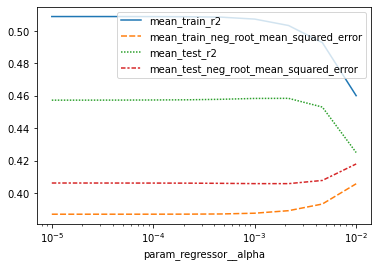

In [49]:
m1, features = modelpreparation(SEUmodel)

# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-5, -2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Lasso(tol=1e-4, max_iter=1e5)

# Preprocessing et fit du modèle
gspipeline = crossval_GS("SiteEnergyUse_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults, _ = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="alpha")

**Réduction de la complexité**

On commence par afficher les poids des différentes colonnes pour la valeur optimale de alpha déterminée par validation croisée. On sélectionne ensuite un sous-ensemble de ces colonnes: on ne retiendra que celles dont les poids sont supérieurs à 5%

In [50]:
# chargement du modèle et des variables associées
m1, features = modelpreparation(SEUmodel)

# Préparation des sets d'entraînement et de test
X = m1[features]
y = m1["SiteEnergyUse_log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Utilisation de Lasso pour recherche les valeurs des poids pour alpha déterminé par validation croisée 
# ci-dessus
lasso = Lasso(alpha=2.15e-4, max_iter=1e5)

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
pipeline = create_pipeline(lasso, X_train, regressor=True)
pipeline.fit(X_train, y_train)
coefs = pipeline.named_steps['regressor'].coef_

# Affichage des résultats dans un dataframe
# Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
base_cols = X_train.dtypes[X_train.dtypes!='category'].index

# Colonnes correspondant au dataframe transformé
onehot_cols = pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
labels = np.concatenate((updated_cols,
                         ['F1', 'F2', 'F3', 'F4'], 
                         onehot_cols,
                         ))
labels = pd.Index(labels)
print("Poids affectés aux différentes variables par Lasso pour alpha=2.15e-3:")
print('')
print(pd.DataFrame(data={"coefficient":np.abs(coefs)}, index=labels)
      .sort_values(by=['coefficient'],
                   ascending=False))

# Utilisation de Lasso pour recherche les valeurs des poids pour alpha déterminé par validation croisée ci-dessus
lasso = Lasso(alpha=2.15e-4, max_iter=1e5)

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
pipeline = create_pipeline(_, X_train)
X_train_transf = pipeline.fit_transform(X_train)
select = SelectFromModel(estimator=lasso, threshold=0.055).fit(X_train_transf, y_train)
X_train_sel = select.transform(X_train_transf)

Poids affectés aux différentes variables par Lasso pour alpha=2.15e-3:

                                        coefficient
x4_Hotel                               2.875790e-01
x4_Large Office_Office                 2.815284e-01
x4_Non-Refrigerated Warehouse_Other    2.715101e-01
x4_Other_Distribution Center           2.053359e-01
x1_2                                   1.470798e-01
F1                                     1.310124e-01
x1_11                                  1.303308e-01
x2_None                                1.197208e-01
x4_Other_Office                        1.155248e-01
x4_Other                               1.006442e-01
x1_10                                  9.944747e-02
x1_8                                   8.487794e-02
x1_4                                   8.456393e-02
x1_1                                   7.076786e-02
x3_None                                6.285925e-02
x1_12                                  6.220537e-02
F2                                     6.106

Seules trois variables sont annulées (voire cinq si on considère que 4.6e-17 et 1.15e-17 sont égaux à zéro), donc le résultat est très modeste.

In [ ]:
lr = LinearRegression()
lr.fit(X_train_sel, y_train)
X_test_sel = X_test.transform(X_test)
lr.score()

On va essayer le même type d'analyse avec RandomForestRegressor, qui possède l'attribut "feature_importances_" permettant, en association avec SelectFromModel de sélectionner les variables pertinentes. Comme RandomForestRegressor.feature_importances_ souffre de potentiels biais (notamment envers les variables avec un grand nombre de modalités), on va également inspecter l'importance des différentes variables grâce à sklearn.inspection.permutation_importance. On en déduira deux modèles, qu'on pourra alors comparer pour sélectionner le meilleur.

## III.3 kNN


Résultat pour la cible SiteEnergyUse:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 15}

Performance en généralisation sur le jeu de test : 0.650
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.620 +/- 0.010
RMSE: 0.340 +/- 0.007

Scores moyens sur le jeu de test, avec le meilleur modèle:
R2: 0.566 +/- 0.050
RMSE: 0.363 +/- 0.033


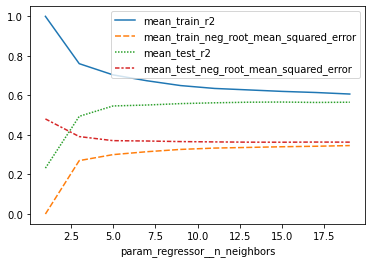


Résultat pour la cible TotalGHGEmissions:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 9}

Performance en généralisation sur le jeu de test : 0.702
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.694 +/- 0.012
RMSE: 0.347 +/- 0.008

Scores moyens sur le jeu de test, avec le meilleur modèle:
R2: 0.612 +/- 0.055
RMSE: 0.390 +/- 0.036


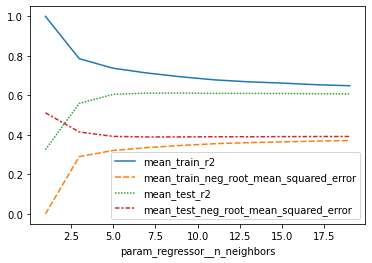

In [87]:
from sklearn.neighbors import KNeighborsRegressor
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("\nRésultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles du nombre de plus proches voisins
    params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
    
    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')
    
    # modèle
    model = KNeighborsRegressor()
    
    # chargement du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)
    
    # DataFrame des résultats de la validation croisée
    cvresults, _ = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, axis_scale="linear", plot_param="n_neighbors")
    

    #key_prefix = "param_regressor__"
#
    #mean_scores = cvresults.loc[
    #    cvresults[key_prefix+"n_neighbors"]==gspipeline.best_params_["regressor__n_neighbors"],
    #    ["mean_train_r2", "mean_train_neg_root_mean_squared_error", 
    #     "mean_test_r2", "mean_test_neg_root_mean_squared_error"]].mean()
#
    #print("Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:")
    #print("R2: {:.3f} +/- {:.3f}".format(mean_scores[0], cvresults.iloc[0]["std_train_r2"]))
    #print("RMSE: {:.3f} +/- {:.3f}".format(mean_scores[1], cvresults.iloc[0]["std_train_neg_root_mean_squared_error"]))
    #print('')
    #print("Scores moyens sur le jeu de test, avec le meilleur modèle:")
    #print("R2: {:.3f} +/- {:.3f}".format(mean_scores[2], cvresults.iloc[0]["std_test_r2"]))
    #print("RMSE: {:.3f} +/- {:.3f}".format(mean_scores[3], cvresults.iloc[0]["std_test_neg_root_mean_squared_error"]))
    #print("="*80)

## III.5 Feature importance avec RandomForest

On reprend le jeu de données initial pour déterminer la valeur optimale de l'hyperparamètre n_estimators

Résultat pour la cible SiteEnergyUse:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 1000}

Performance en généralisation sur le jeu de test : 0.779
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.962 +/- 0.010
RMSE: 0.107 +/- 0.007

Scores moyens sur le jeu de test, avec le meilleur modèle:
R2: 0.722 +/- 0.050
RMSE: 0.291 +/- 0.033


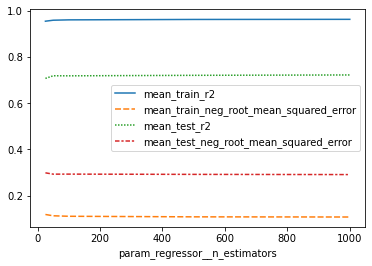

Résultat pour la cible TotalGHGEmissions:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 500}

Performance en généralisation sur le jeu de test : 0.823
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.969 +/- 0.001
RMSE: 0.111 +/- 0.002

Scores moyens sur le jeu de test, avec le meilleur modèle:
R2: 0.766 +/- 0.042
RMSE: 0.302 +/- 0.030


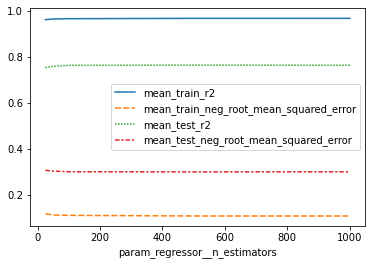

In [88]:
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    
    print("Résultat pour la cible {}:".format(target_name))
    # Valeurs possibles du paramètre alpha
    params = {"n_estimators" : [25,50,100, 500, 1000]}

    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')

    # modèle
    model = RandomForestRegressor(oob_score=True)

    # Preprocessing et fit du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)

    # DataFrame des résultats de la validation croisée
    cvresults, result_cols = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, plot_param="n_estimators", axis_scale='linear')

Recherche d'un modèle plus simple à l'aide de deux méthodes:
* RandomForestRegressor.feature_importances_
* sklearn.inspection.permutation_importance

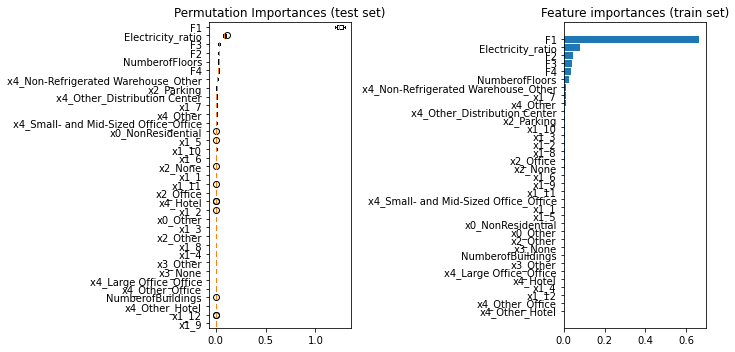

In [37]:
from sklearn.inspection import permutation_importance

# Cible qu'on cherche à prédire
target = "SiteEnergyUse_log"

# chargement du modèle
m1, features = modelpreparation(model1)


# Séparation prédicteurs - cible
X = m1[features]
y = m1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Permutation importance
# Pipeline de transformation du dataset uniquement
transf_pipeline = create_pipeline(_, X_train)
X_train_transf = transf_pipeline.fit_transform(X_train)
X_test_transf = transf_pipeline.transform(X_test)

# Création d'un nouvel estimateurs
rfr = RandomForestRegressor(n_estimators=50, oob_score=True)
rfr.fit(X_train_transf, y_train)

result = permutation_importance(rfr, X_test_transf, y_test, n_repeats=10, random_state=0)
sorted_idx = result.importances_mean.argsort()

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
rfr1 = RandomForestRegressor(n_estimators=50, oob_score=True)
reg = create_pipeline(rfr1, X_train, regressor=True)

# Fit transform
reg.fit(X_train, y_train)

# Feature importances
feat_importances = reg.named_steps['regressor'].feature_importances_

# Affichage des résultats dans un dataframe
# Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
base_cols = X_train.dtypes[X_train.dtypes!='category'].index

# Colonnes correspondant au dataframe transformé
onehot_cols = pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
labels = np.concatenate((updated_cols,
                         ['F1', 'F2', 'F3', 'F4'], 
                         onehot_cols,
                         ))
labels = pd.Index(labels)    
feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                   index=labels).sort_values(by=['feature importance'],
                                                             ascending=False)

# Affichage des features par ordre d'importance
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax1.set_title("Permutation Importances (test set)")

f = feature_importances["feature importance"]
ax2.barh(f.index, f)
ax2.set_title("Feature importances (train set)")
ax2.invert_yaxis()
fig.tight_layout()
plt.show()

Les deux méthodes donnent des résultats remarquablement similaires. De plus, cette fois-ci un grand nombre de variables sont "annulées", ce qui permet d'effectuer une sélection intéressante.
On va réutiliser RandomForestRegressor sur une sous-sélection basée sur les résultats obtenus, avec le meilleur hyperparamètre (ici on choisit 100 car on n'observe pas d'amélioration significative des performances avec un nombre d'estimateurs plus grand).

In [38]:
# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
rfr2 = RandomForestRegressor(n_estimators=500, oob_score=True)

select = SelectFromModel(estimator=rfr, threshold=0.01).fit(X_train_transf, y_train)
print("Variables sélectionnées:")
print(feature_importances[feature_importances["feature importance"]>1e-2].index.values)
X_train_sel = select.transform(X_train_transf)
X_test_sel = select.transform(X_test_transf)
rfr2.fit(X_train_sel, y_train)
print("score R2 sur le jeu de test avec la sélection de variables: {:.3f}".format(rfr2.score(X_test_sel, y_test)))

Variables sélectionnées:
['F1' 'Electricity_ratio' 'F2' 'F3' 'F4' 'NumberofFloors'
 'x4_Non-Refrigerated Warehouse_Other']
score R2 sur le jeu de test avec la sélection de variables: 0.772


# IV Choix du modèle

On reprend tous les modèles explorés avec les hyperparamètres déterminés par validation croisée et on les fait tourner sur le jeu d'entraînement pour comparer les scores et les temps de fit/prediction. On choisira lemodèle qui représente le meilleur compromis entre ces grandeurs.

Linear Regression
train time: 0.062s
test time:  0.015s
score:   0.388

Lasso
train time: 0.056s
test time:  0.015s
score:   0.385

kNN
train time: 0.067s
test time:  0.107s
score:   0.543

Random Forest
train time: 1.846s
test time:  0.049s
score:   0.734

Random Forest with feature selection
train time: 1.624s
test time:  0.027s
score:   0.741



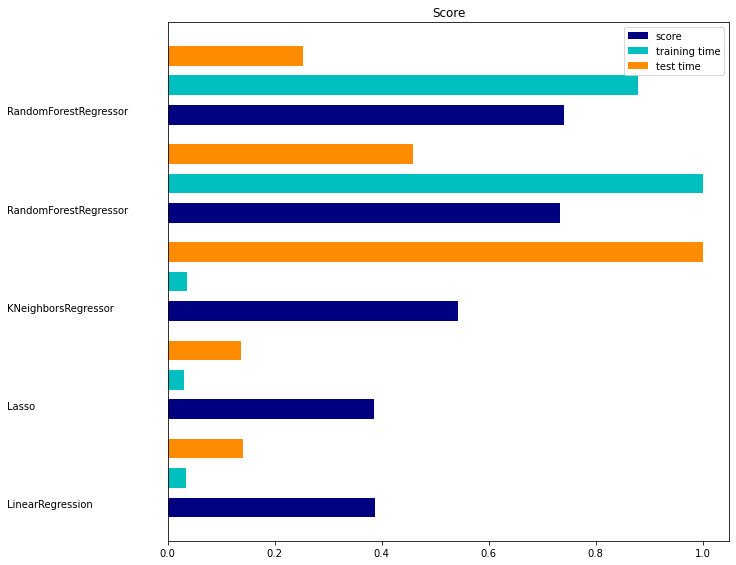

In [39]:
m1, features = modelpreparation(model1)
X = m1[features]
y = m1["SiteEnergyUse_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


from time import time
def benchmark(reg, X_train, X_test, y_train, y_test):

    t0 = time()
    reg.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = reg.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = r2_score(y_test, pred)
    print("score:   %0.3f" % score)

    print()
    
    try:
        reg_descr = str(reg.named_steps['regressor']).split('(')[0]
    except:
        reg_descr = str(reg).split('(')[0]
    
    return reg_descr, score, train_time, test_time

results = []
for regr, name in (
        (LinearRegression(), "Linear Regression"),
        (Lasso(alpha=2.15e-3, max_iter=1e5), "Lasso"),
        (KNeighborsRegressor(n_neighbors=9), "kNN"),
        (RandomForestRegressor(), "Random Forest")):
    reg = create_pipeline(regr, X_train, regressor=True)
    print('=' * 80)
    print(name)
    results.append(benchmark(reg, X_train, X_test, y_train, y_test))
    

rfr2 = RandomForestRegressor()
rfr = RandomForestRegressor()
transf_pipe = create_pipeline(_, X_train)
X_train_transf = transf_pipe.fit_transform(X_train)
X_test_transf = transf_pipe.transform(X_test)

select = SelectFromModel(estimator=rfr, threshold=0.01).fit(X_train_transf, y_train)
X_train_sel = select.transform(X_train_transf)
X_test_sel = select.transform(X_test_transf)
print('=' * 80)
print('Random Forest with feature selection')
results.append(benchmark(rfr2, X_train_transf, X_test_transf, y_train, y_test))


indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

reg_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, reg_names):
    plt.text(-.3, i, c)

plt.show()

RandomForestRegressor est de loin le meilleur algorithme. Sélectionner les features n'apporte qu'une amélioration modeste au temps d'entraînement, néanmoins grâce à des performances à peines entamées on décide de choisir ce modèle pour réaliser les prédictions de SiteEnergyUse, puis TotalGHGEmissions.

# V ENERGYSTARScore

Avant de passer à la prédiction de TotalGHGEmissions, on cherche à évaluer l'importance de ENERGYSTARScore pour la prédiction. Comme vu lors de l'analyse exploratoire, ENERGYSTARScore est corrélée (faiblement) aux valeurs moyennes de SourceEUIWN, GHGEmissionsIntensity, et ces dernières sont corrélées à TotalGHGEmissions via PropertyGFABuilding(s). On souhaite maintenant quantifier cette corrélation.

TotalGHGEmissions (log) vs ENERGYSTARScore:
R2 sur le jeu de données: 0.018


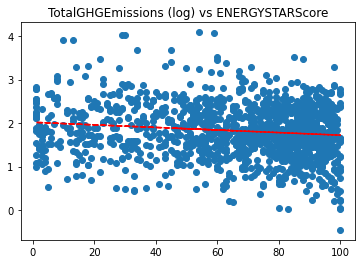

GHGEmissionsIntensity vs ENERGYSTARScore:
R2 sur le jeu de données: 0.114


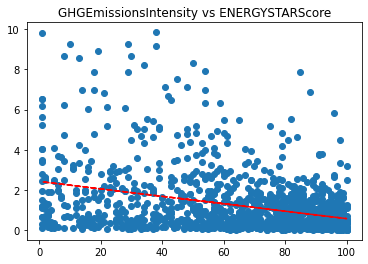

GHGEmissionsIntensity moyenne vs ENERGYSTARScore:
R2 sur le jeu de données: 0.377


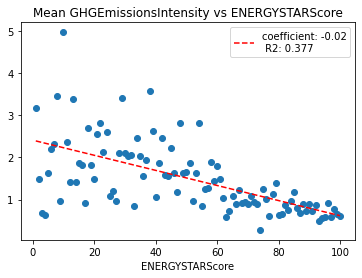

In [40]:
# prédicteurs
escmodel = model1.copy()
escmodel.dropna(subset=["ENERGYSTARScore"], inplace=True)

features = "ENERGYSTARScore"
target = "TotalGHGEmissions_log"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("TotalGHGEmissions (log) vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["TotalGHGEmissions_log"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("TotalGHGEmissions (log) vs ENERGYSTARScore")
plt.show()

features = "ENERGYSTARScore"
target = "GHGEmissionsIntensity"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["GHGEmissionsIntensity"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("GHGEmissionsIntensity vs ENERGYSTARScore")
plt.show()

# Régression linéaire sur les valeurs moyennes de GHGEmissionsIntensity pour chaque valeur de ENERGYSTARScore
X = escmodel.groupby(features).mean()[target].index.to_numpy().reshape(-1, 1)
y = escmodel.groupby(features).mean()[target].values

lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity moyenne vs ENERGYSTARScore:")
score = lr.score(X,y)
print("R2 sur le jeu de données: {:.3f}".format(score))
coef = lr.coef_
intercept = lr.intercept_

indices = escmodel.groupby(features).mean()[target].index.values
fig, ax = plt.subplots()
ax.scatter(escmodel.groupby(features).mean()[target].index.to_numpy(),  y)
ax.plot(indices, intercept + indices*coef, 'r--', label="coefficient: {:.2f}\n R2: {:.3f}".format(coef[0], score))
ax.set_title("Mean GHGEmissionsIntensity vs ENERGYSTARScore")
ax.set_xlabel("ENERGYSTARScore")
ax.legend()
plt.show()

ENERGYSTARScore est clairement corrélé aux _valeurs moyennes_ de GHGEmissionsIntensity, plus qu'aux valeurs "brutes". Le coefficient R2 existant etre TotalGHGEmissions_log et ENERGYSTARScore (R2=0.02) indique une absence de corrélation (linéaire) entre les deux variables. ENERGYSTARScore n'est donc pas d'un grand intérêt pour prédire TotalGHGEmissions.

# VI Prédiction de TotalGHGEmissions

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 50}

Performance en généralisation sur le jeu de test : 0.995
Performance(s) moyenne(s) sur le jeu d'entraînement:


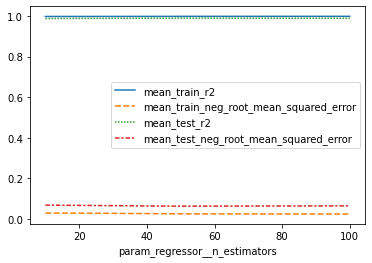

In [41]:
m1, features = modelpreparation(model1)

pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

features = ["SiteEnergyUse_log", "Electricity_ratio", "BuildingType"] + pca_cols

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# hyperparamètre
params = {"n_estimators":[10, 
                          25,
                          50, 
                          100,
                          #500,
                          #1000
                         ]
         }
# modèle
model = RandomForestRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults, _ = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="n_estimators", axis_scale='linear')

A condition d'utiliser SiteEnergyUse (après application du log et de StandardScaler qui plus est), on obtient des résultats très satisfaisant pour TotalGHGEmissions. On va donc explorer un modèle qui combinera la prédiction sur SiteEnergyUse dans un premier temps, et se servira de cette prédiction pour prédire TotalGHGEmissions.

In [89]:
m1, features = modelpreparation(model1)


pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

# D'abord, prédiction de SiteEnergyUse
features = pca_cols + ["Electricity_ratio", "YearBuilt", "MainPropertyType", "SecondLargestPropertyUseType"]
X = m1[features]
y = m1[["SiteEnergyUse_log", "TotalGHGEmissions_log"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # split à 50% et non l'habituel 80-20
rfr = RandomForestRegressor(n_estimators=500)
SEUpipeline = create_pipeline(rfr, X_train, regressor=True)

SEUpipeline.fit(X_train, y_train["SiteEnergyUse_log"])
seu_predictions = SEUpipeline.predict(X_test)
seu_score = r2_score(y_test["SiteEnergyUse_log"], seu_predictions)
X_test.loc[:, "SEU_log_pred"] = seu_predictions

# Prediction de TotalGHGEmissions
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_test, 
                                                                            y_test["TotalGHGEmissions_log"],
                                                                            test_size=0.2)
rfr1 = RandomForestRegressor(n_estimators=500)
GHGpipeline = create_pipeline(rfr1, X_train_final, regressor=True)
GHGpipeline.fit(X_train_final, y_train_final)
ghg_predictions = GHGpipeline.predict(X_test_final)
ghg_score = r2_score(y_test_final, ghg_predictions)

print("Performance en prédiction sur le jeu de test:")
print("R2 pour la prédiction de SiteEnergyUse_log: {:.3f}".format(seu_score))
print("R2 pour la prédiction de TotalGHGEmissions_log: {:.3f}".format(ghg_score))

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Performance en prédiction sur le jeu de test:
R2 pour la prédiction de SiteEnergyUse_log: 0.735
R2 pour la prédiction de TotalGHGEmissions_log: 0.752


On parvient à une prédiction de 73% pour SiteEnergyUse, et d'environ 75% pour TotalGHGEmissions.

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 500}

Performance en généralisation sur le jeu de test : 0.815
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.968 +/- 0.001
RMSE: 0.112 +/- 0.002

Scores moyens sur le jeu de test, avec le meilleur modèle:
R2: 0.757 +/- 0.044
RMSE: 0.308 +/- 0.032


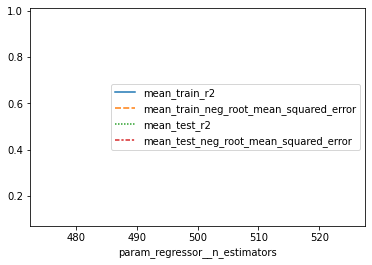

In [90]:
m1, features = modelpreparation(GHGmodel)

pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

features = ["YearBuilt", "Electricity_ratio", "MainPropertyType", "SecondLargestPropertyUseType"] + pca_cols

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# hyperparamètre
params = {"n_estimators":[#10, 
                          #25,
                          #50, 
                          #100,
                          500,
                          #1000
                         ]
         }
# modèle
model = RandomForestRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults, _ = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="n_estimators", axis_scale='linear')